In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# wrangling
import pandas as pd
import numpy as np

# preparing
#from sklearn.model_selection import train_test_split

# visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# exploring
import scipy.stats as stats
import pandas_profiling

# modeling
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# from sklearn.linear_model import LinearRegression
# from statsmodels.formula.api import ols
# from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
# from sklearn.feature_selection import f_regression
# from math import sqrt

# 3D projection
from mpl_toolkits.mplot3d import Axes3D

pd.options.display.float_format = '{:20,.2f}'.format

# my modules
import acquire
import summarize
import prepare

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

In [2]:
df = acquire.get_zillow_data()

- Read in 52,169 rows

In [3]:
df.shape

(52169, 72)

In [4]:
df.bedroomcnt.value_counts()

 3.00    23296
 4.00    15206
 2.00     8315
 5.00     3967
 6.00      634
 1.00      608
 7.00      106
 8.00       24
 9.00        8
10.00        2
12.00        1
14.00        1
11.00        1
Name: bedroomcnt, dtype: int64

In [5]:
df.bathroomcnt.value_counts()

 2.00    21832
 3.00    10646
 1.00     9518
 2.50     3931
 4.00     2225
 3.50      916
 1.50      839
 5.00      802
 4.50      686
 6.00      320
 5.50      224
 7.00       88
 8.00       53
 6.50       47
 7.50       16
 9.00       13
10.00        5
11.00        3
 8.50        3
13.00        1
18.00        1
Name: bathroomcnt, dtype: int64

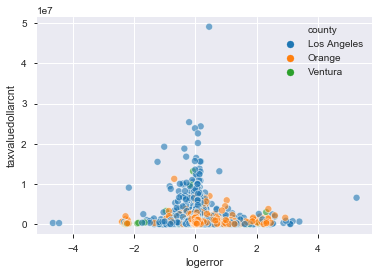

In [6]:
sns.scatterplot(data=df, x="logerror", y="taxvaluedollarcnt", hue="county", hue_order=["Los Angeles", "Orange", "Ventura"] , alpha=.6)

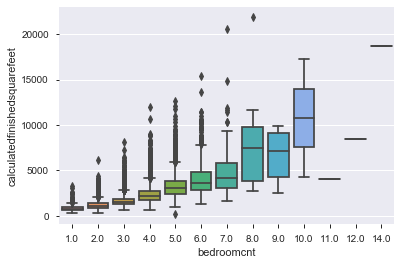

In [7]:
sns.boxplot(df.bedroomcnt, df.calculatedfinishedsquarefeet)

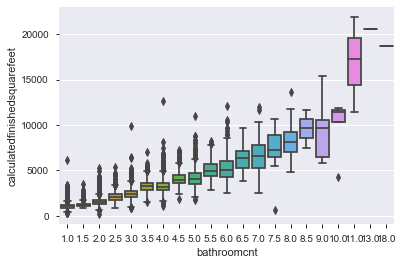

In [8]:
sns.boxplot(df.bathroomcnt, df.calculatedfinishedsquarefeet)

- Handle outliers by removing values < Q1 - IQR * 1.5 and values > Q3 + IQR * 1.5

In [9]:
df = prepare.remove_outliers_iqr(df, columns=["bedroomcnt", "bathroomcnt"], k=1.5)
df.shape

(49543, 72)

In [10]:
df.bedroomcnt.value_counts()

3.00    23243
4.00    14792
2.00     8313
5.00     3195
Name: bedroomcnt, dtype: int64

In [11]:
df.bathroomcnt.value_counts()

2.00    21718
3.00    10477
1.00     8982
2.50     3918
4.00     2063
3.50      899
1.50      838
4.50      648
Name: bathroomcnt, dtype: int64

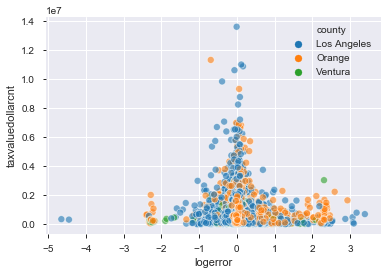

In [12]:
sns.scatterplot(data=df, x="logerror", y="taxvaluedollarcnt", hue="county", hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6)

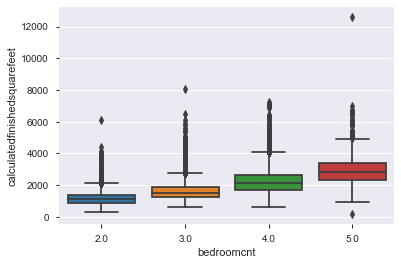

In [13]:
sns.boxplot(df.bedroomcnt, df.calculatedfinishedsquarefeet)

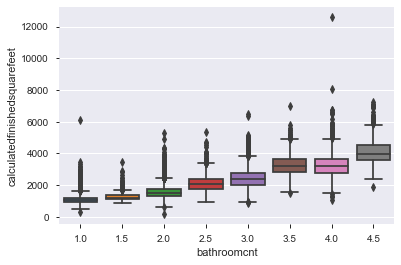

In [14]:
sns.boxplot(df.bathroomcnt, df.calculatedfinishedsquarefeet)

### Stats Testing to Decide on Feature Engineering

- Here I use a chi2 test to look at categorical features.

- $H_0$: Bathroomcnt is independent of how many bedrooms a home has.

- $H_a$: Bathroomcnt is not independent of how many bedrooms a home has.

In [15]:
contingency_table = pd.crosstab(df.bedroomcnt, df.bathroomcnt)
contingency_table

bathroomcnt,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5
bedroomcnt,,,,,,,,
2.00,5063,229,2526,191,278,15,11,0
3.00,3669,504,13319,1884,3267,206,352,42
4.00,219,100,5533,1657,5431,514,1023,315
5.00,31,5,340,186,1501,164,677,291


In [16]:
_, p, _, expected = stats.chi2_contingency(contingency_table)

In [17]:
print(f"The p-value of the contingency test")

The p-value of the contingency test


- Based on the p_value of 0 from the chi2 test above, I reject the Null Hypothesis that bathroomcnt is independent of how many bedrooms a home has.

- Based on rejecting the Null Hypothesis, I will combine the two features into a single feature that is a ratio of bedrooms to bathrooms.

- Drop columns and convert categorical columns to dtype category to run more accurate stats tests

In [18]:
contingency_table = pd.crosstab(df.bedroomcnt, df.yearbuilt)
contingency_table

yearbuilt,1878.0,1880.0,1882.0,1885.0,1887.0,1888.0,1889.0,1890.0,1893.0,1894.0,...,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0
bedroomcnt,,,,,,,,,,,,,,,,,,,,,
2.00,0,0,1,2,0,0,0,2,2,0,...,3,1,4,3,1,1,2,13,1,0
3.00,1,0,0,1,1,3,0,3,1,1,...,89,54,32,32,27,29,45,40,17,0
4.00,0,0,0,2,0,0,1,0,0,0,...,116,45,31,45,44,52,57,78,38,1
5.00,0,1,0,0,2,0,0,1,0,0,...,40,16,5,11,12,11,15,14,12,1


In [19]:
df.columns

Index(['county', 'tax_rate', 'id', 'parcelid', 'airconditioningtypeid',
       'airconditioningdesc', 'architecturalstyletypeid',
       'architecturalstyledesc', 'basementsqft', 'bathroomcnt', 'bedroomcnt',
       'buildingclasstypeid', 'buildingclassdesc', 'buildingqualitytypeid',
       'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'decktypeid',
       'finishedfloor1squarefeet', 'finishedsquarefeet12',
       'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50',
       'finishedsquarefeet6', 'fips', 'state', 'fireplacecnt', 'fullbathcnt',
       'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'heatingorsystemdesc', 'latitude', 'longitude',
       'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'pooltypeid10',
       'pooltypeid2', 'pooltypeid7', 'propertycountylandusecode',
       'propertylandusetypeid', 'propertylandusedesc', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
      

In [20]:
cols_to_remove = ['id', 'parcelid', 'airconditioningtypeid',
       'airconditioningdesc', 'architecturalstyletypeid',
       'architecturalstyledesc', 'basementsqft',
       'buildingclasstypeid', 'buildingclassdesc', 'buildingqualitytypeid',
       'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'finishedsquarefeet12',
       'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50',
       'finishedsquarefeet6', 'fips', 'state', 'fireplacecnt', 'fullbathcnt',
       'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'heatingorsystemdesc', 'poolcnt', 'poolsizesum', 'pooltypeid10',
       'pooltypeid2', 'pooltypeid7', 'propertycountylandusecode',
       'propertylandusetypeid', 'propertylandusedesc', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'storytypeid',
       'storydesc', 'threequarterbathnbr', 'unitcnt',
       'yardbuildingsqft17', 'yardbuildingsqft26',
       'numberofstories', 'fireplaceflag', 'structuretaxvaluedollarcnt',
       'assessmentyear', 'landtaxvaluedollarcnt', 'typeconstructiontypeid',
       'typeconstructiondesc', 'censustractandblock', 'transactiondate',
       'transactions']

In [21]:
df = prepare.remove_columns(df, cols_to_remove)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49543 entries, 0 to 52167
Data columns (total 12 columns):
county                          49543 non-null object
tax_rate                        49538 non-null float64
bathroomcnt                     49543 non-null float64
bedroomcnt                      49543 non-null float64
calculatedfinishedsquarefeet    49538 non-null float64
latitude                        49543 non-null float64
longitude                       49543 non-null float64
lotsizesquarefeet               49272 non-null float64
taxvaluedollarcnt               49542 non-null float64
yearbuilt                       49512 non-null float64
taxamount                       49539 non-null float64
logerror                        49543 non-null float64
dtypes: float64(11), object(1)
memory usage: 6.2+ MB
